In [1]:
!pip install -q \
    transformers==4.10.3\
    pyarrow==15.0.0 \
    git+https://github.com/huggingface/peft.git \
    git+https://github.com/salaniz/pycocoevalcap \
    bitsandbytes \
    evaluate \
    sacrebleu \
    nltk \
    rouge-score \
    torch
!pip install -q transformers accelerate
!pip install --upgrade transformers
!pip install peft
!pip uninstall numpy -y
!pip install numpy --upgrade
!pip install sacrebleu nltk pycocoevalcap
!pip install pycocoevalcap

import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW

from torch.utils.data import Dataset
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments

from peft import LoraConfig, get_peft_model

import nltk
nltk.download('punkt')
from tqdm.auto import tqdm


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

  Using cached sacrebleu-2.5.1-py3-none-any.whl.metadata (51 kB)
  Using cached portalocker-3.2.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached sacrebleu-2.5.1-py3-none-any.whl (104 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.5 MB/s eta 0:00:00
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached portalocker-3.2.0-py3-none-any.whl (22 kB)


ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

In [1]:

import os
# Create directories for your data
os.makedirs('/kaggle/working/datasets/train_ROCOv2', exist_ok=True)
os.makedirs('/kaggle/working/datasets/test_ROCOv2', exist_ok=True)


# Download the main ROCOV2 file
!wget -O /kaggle/working/ROCOV2.zip https://zenodo.org/api/records/10821435/files-archive
# Unzip the main ROCOV2 file
!unzip /kaggle/working/ROCOV2.zip -d /kaggle/working/

# Unzip the train images
!unzip /kaggle/working/train_images.zip -d /kaggle/working/datasets/train_ROCOv2/

# Unzip the test images
!unzip /kaggle/working/test_images.zip -d /kaggle/working/datasets/test_ROCOv2/

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004946.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004947.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004948.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004949.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004950.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004951.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004952.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004953.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004954.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004955.jpg  
  inflating: /kaggle/working/datasets/test_ROCOv2/test/ROCOv2_2023_test_004956.jpg  
 extracting: /

In [ ]:
import pandas as pd
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset


drive_path = '/kaggle/working/'


train_images_path = os.path.join(drive_path, 'datasets/train_ROCOv2/train')
test_images_path = os.path.join(drive_path, 'datasets/test_ROCOv2/test')
train_csv_path = os.path.join(drive_path, 'train_captions.csv')
test_csv_path = os.path.join(drive_path, 'test_captions.csv')


df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)


df_train = df_train.sample(frac=0.1, random_state=42).reset_index(drop=True)


from PIL import Image


class ROCOv2Dataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, tokenizer, max_length=64):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['ID']

        
        if not image_id.lower().endswith('.jpg'):
            image_id += '.jpg'

        image_path = os.path.join(self.image_dir, image_id)

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        caption = row['Caption']
        input_ids = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        ).input_ids.squeeze()

        return {
            "pixel_values": pixel_values,
            "labels": input_ids
        }



In [ ]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from peft import get_peft_model, LoraConfig, TaskType


model_name = "ydshieh/vit-gpt2-coco-en"
model = VisionEncoderDecoderModel.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],  
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)


model.decoder = get_peft_model(model.decoder, peft_config)
model.decoder.print_trainable_parameters()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

trainable params: 1,179,648 || all params: 153,986,304 || trainable%: 0.7661


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [4]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import torch

train_dataset = ROCOv2Dataset(df_train, train_images_path, processor, tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = Seq2SeqTrainingArguments(
    output_dir="./vit-gpt2-roco-lora",
    per_device_train_batch_size=8,  # افزایش batch size
    gradient_accumulation_steps=2,  # جمع چند batch برای آپدیت
    num_train_epochs=6,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # فعال کردن half precision
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,4.230600
200,3.504600
300,3.314300
400,3.277700
500,3.184600
600,3.285700
700,3.248700
800,3.175100
900,3.112200
1000,3.146000


TrainOutput(global_step=2250, training_loss=3.1828564046223957, metrics={'train_runtime': 1206.5737, 'train_samples_per_second': 29.817, 'train_steps_per_second': 1.865, 'total_flos': 6.530698508545032e+18, 'train_loss': 3.1828564046223957, 'epoch': 6.0})

In [ ]:
import torch
from tqdm import tqdm
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from PIL import Image
import os
import pandas as pd


model.eval()
model.to(device)


df_test_sample = df_test.head(1000).reset_index(drop=True)

references = []
hypotheses = []
image_ids = []
gt_captions = []
pred_captions = []

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        outputs = model.generate(pixel_values, max_length=64)
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return caption.strip()


for idx, row in tqdm(df_test_sample.iterrows(), total=len(df_test_sample)):
    image_id = row['ID']
    if not image_id.lower().endswith('.jpg'):
        image_id += '.jpg'
    image_path = os.path.join(test_images_path, image_id)

    try:
        pred_caption = generate_caption(image_path)
    except Exception as e:
        print(f"⚠️ Error on {image_id}: {e}")
        continue

    hypotheses.append(pred_caption)
    references.append([row['Caption']])
    image_ids.append(image_id)
    gt_captions.append(row['Caption'])
    pred_captions.append(pred_caption)


res_dict = {img_id: [pred] for img_id, pred in zip(image_ids, pred_captions)}  # داخل لیست!
gts_dict = {img_id: [gt] for img_id, gt in zip(image_ids, gt_captions)}



bleu_scorer = Bleu(4)
cider_scorer = Cider()
meteor_scorer = Meteor()
rouge_scorer = Rouge()

bleu_scores, _ = bleu_scorer.compute_score(gts_dict, res_dict)
cider_score, _ = cider_scorer.compute_score(gts_dict, res_dict)
meteor_score, _ = meteor_scorer.compute_score(gts_dict, res_dict)
rouge_score, _ = rouge_scorer.compute_score(gts_dict, res_dict)

print("\n📊 Evaluation Results on sample:")
print(f"BLEU-1 : {bleu_scores[0]:.4f}")
print(f"BLEU-2 : {bleu_scores[1]:.4f}")
print(f"BLEU-3 : {bleu_scores[2]:.4f}")
print(f"BLEU-4 : {bleu_scores[3]:.4f}")
print(f"CIDEr   : {cider_score:.4f}")
print(f"METEOR  : {meteor_score:.4f}")
print(f"ROUGE-L : {rouge_score:.4f}")


results_df = pd.DataFrame({
    "image_id": image_ids,
    "ground_truth": gt_captions,
    "predicted": pred_captions
})

results_df.to_csv("evaluation_results_2000.csv", index=False)
print("\n📁 نتایج در فایل 'evaluation_results_2000.csv' ذخیره شد.")


100%|██████████| 1000/1000 [25:22<00:00,  1.52s/it]


{'testlen': 14675, 'reflen': 21505, 'guess': [14675, 13675, 13304, 12957], 'correct': [517, 13, 0, 0]}
ratio: 0.6823994419902031

📊 Evaluation Results on sample:
BLEU-1 : 0.0221
BLEU-2 : 0.0036
BLEU-3 : 0.0000
BLEU-4 : 0.0000
CIDEr   : 0.0026
METEOR  : 0.0063
ROUGE-L : 0.0195

📁 نتایج در فایل 'evaluation_results_2000.csv' ذخیره شد.


/tmp/ipython-input-7-121656680.py:21: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-121656680.py:21: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


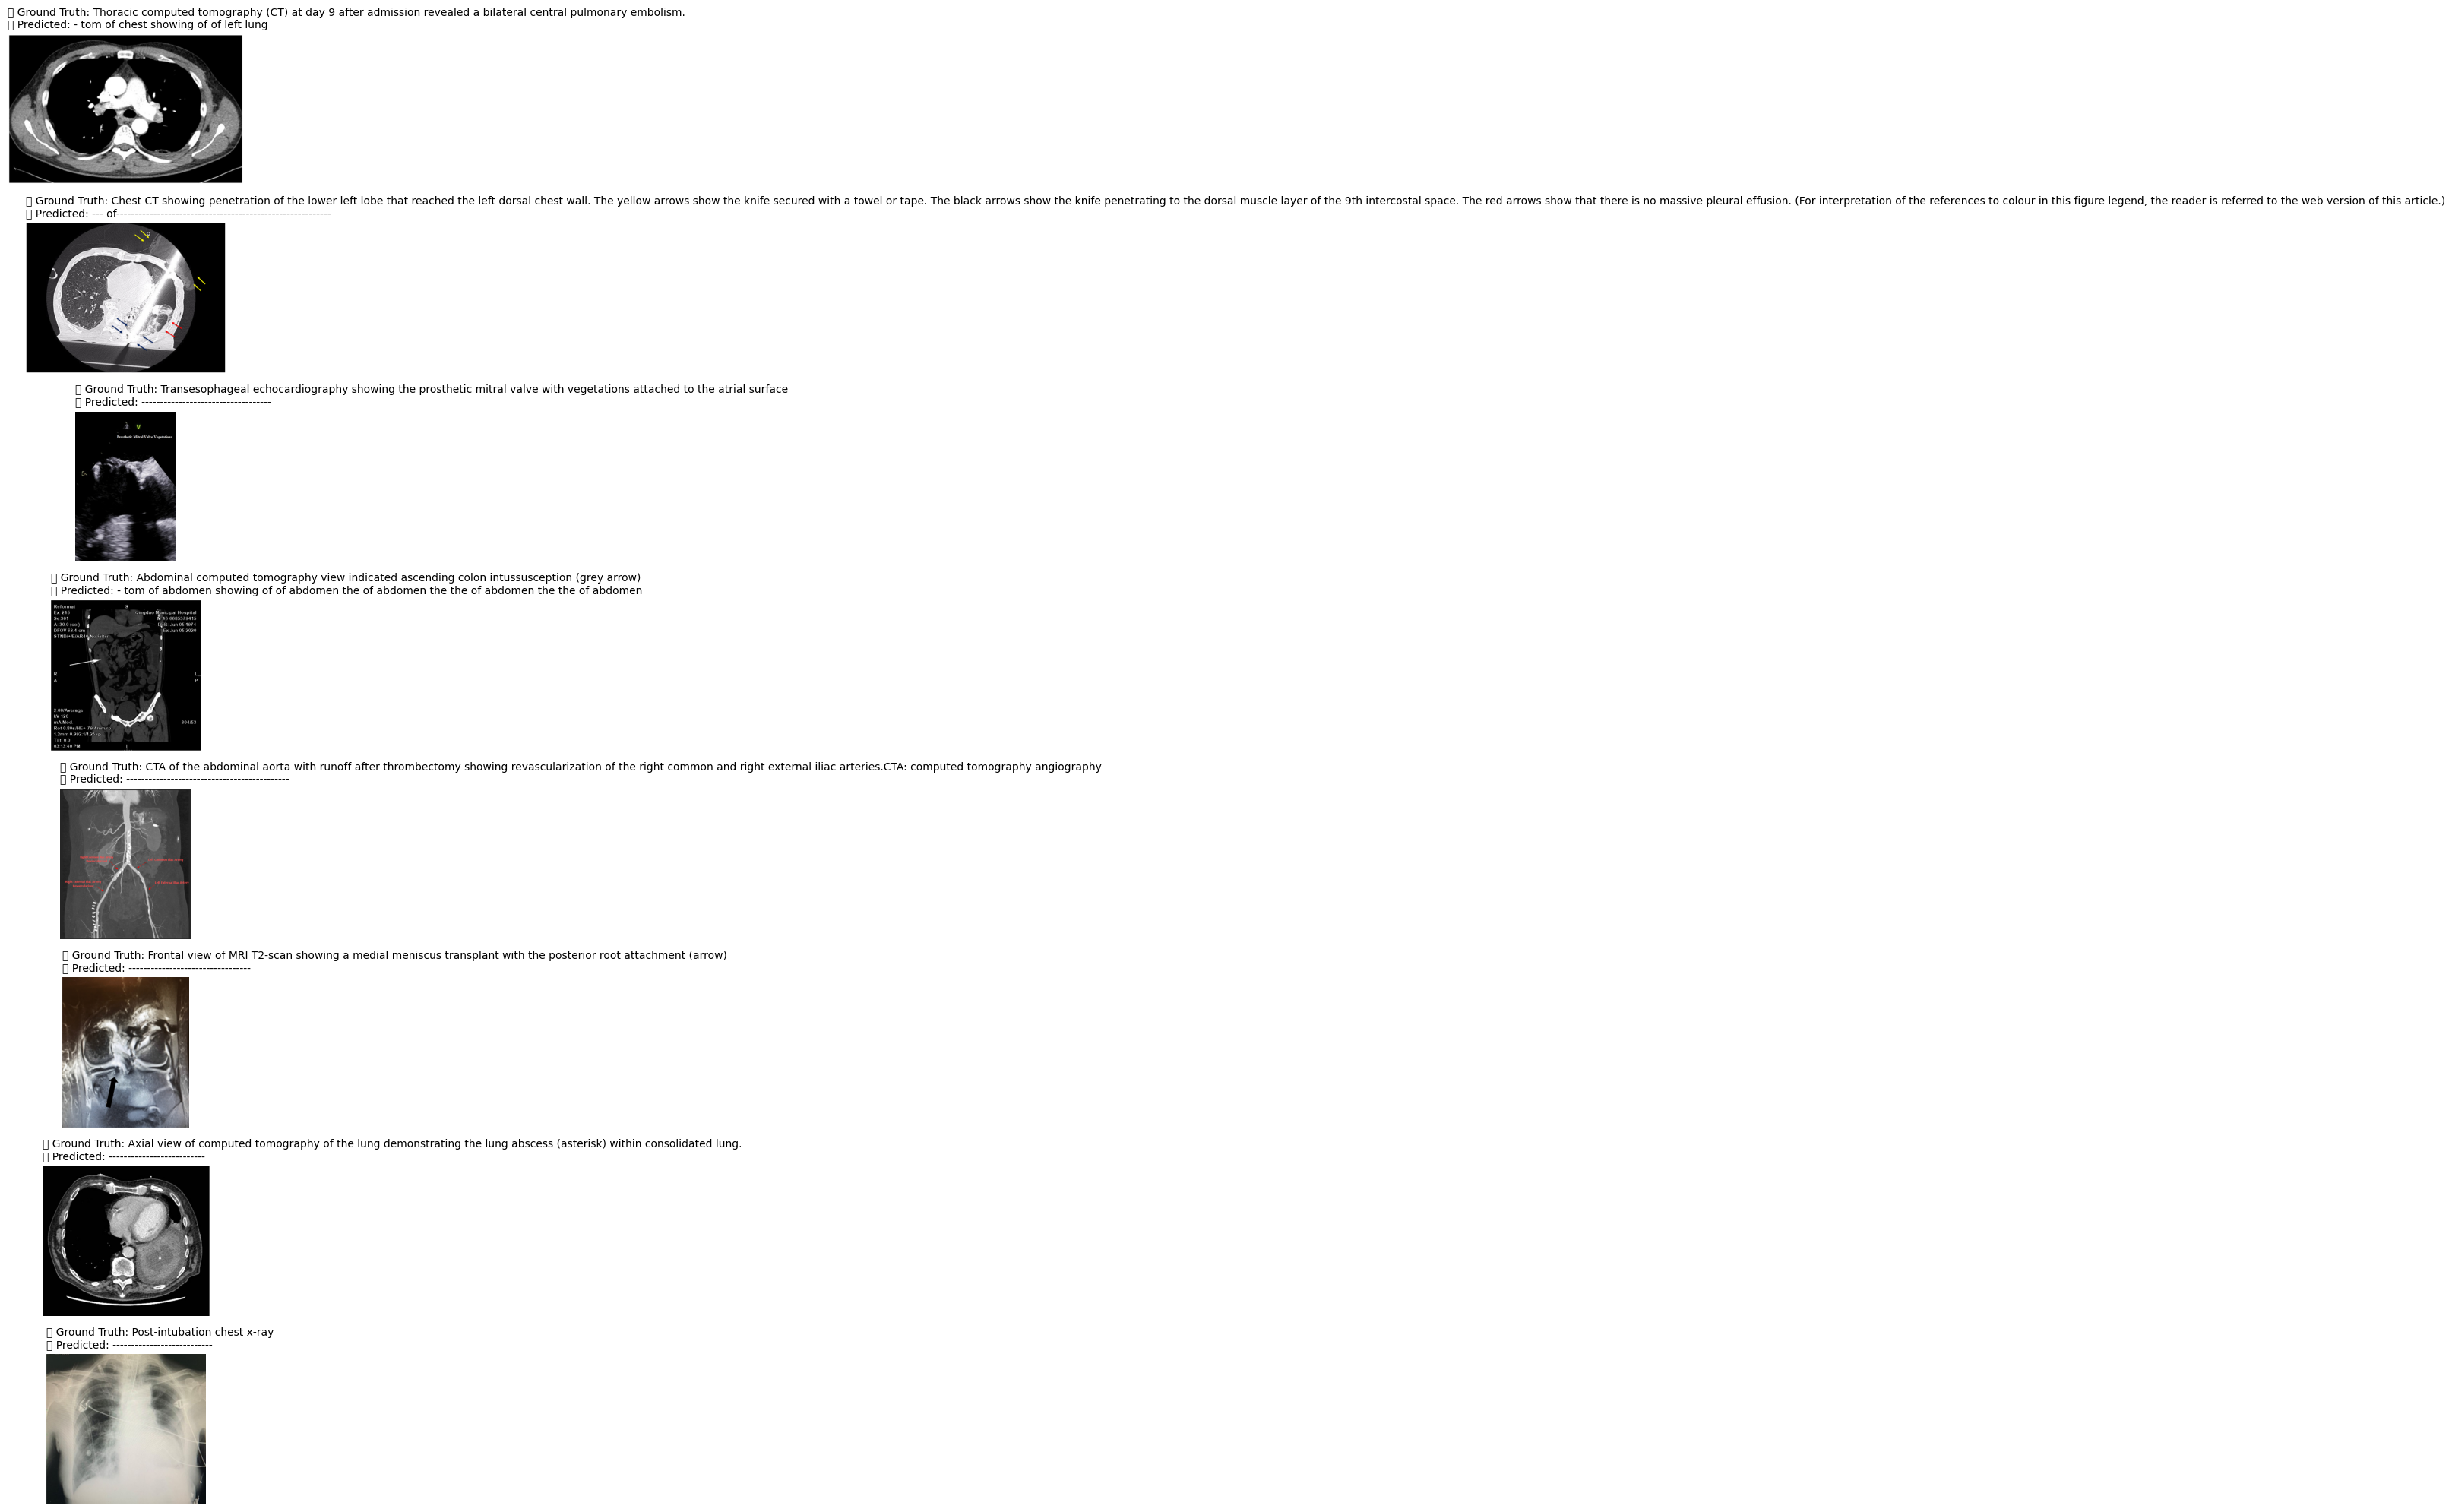

In [ ]:
import matplotlib.pyplot as plt


num_examples_to_show = 8


sample_df = results_df.sample(n=num_examples_to_show, random_state=42).reset_index(drop=True)


plt.figure(figsize=(16, num_examples_to_show * 2.5))

for i in range(num_examples_to_show):
    image_path = os.path.join(test_images_path, sample_df.loc[i, 'image_id'])
    image = Image.open(image_path).convert("RGB")

    plt.subplot(num_examples_to_show, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"🔹 Ground Truth: {sample_df.loc[i, 'ground_truth']}\n🔸 Predicted: {sample_df.loc[i, 'predicted']}", fontsize=10, loc='left')

plt.tight_layout()
plt.show()